In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face

Mounted at /content/gdrive
/content/gdrive/My Drive/Hugging Face


In [ ]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("datasets/surgical_instruments/images/train")
count_images("datasets/surgical_instruments/images/valid")

Total images: 2855
Total images: 841


In [ ]:
# Check train annotations
with open("datasets/surgical_instruments/annotations/instances_train.json") as f:
    train_data = json.load(f)
    print(f"Train images: {len(train_data['images'])}")
    print(f"Train annotations: {len(train_data['annotations'])}")
    print(f"Categories: {train_data['categories']}")

# Check validation
with open("datasets/surgical_instruments/annotations/instances_valid.json") as f:
    valid_data = json.load(f)
    print(f"\nValid images: {len(valid_data['images'])}")
    print(f"Valid annotations: {len(valid_data['annotations'])}")

Train images: 2855
Train annotations: 4895
Categories: [{'id': 1, 'name': 'Grasper'}, {'id': 2, 'name': 'Harmonic_Ace'}, {'id': 3, 'name': 'Myoma_Screw'}, {'id': 4, 'name': 'Needle_Holder'}, {'id': 5, 'name': 'Suction'}, {'id': 6, 'name': 'Trocar'}]

Valid images: 841
Valid annotations: 1215


In [ ]:
import json
from collections import defaultdict
from pprint import pprint

def check_coco_instance_segmentation(ann_file_path):
    with open(ann_file_path, 'r') as f:
        coco_data = json.load(f)

    # Top-level keys
    assert 'images' in coco_data, "'images' key not found"
    assert 'annotations' in coco_data, "'annotations' key not found"
    assert 'categories' in coco_data, "'categories' key not found"

    print(f"📷 Total images: {len(coco_data['images'])}")
    print(f"✏️ Total annotations: {len(coco_data['annotations'])}")
    print(f"🏷️ Total categories: {len(coco_data['categories'])}")

    print("\n🔍 Sample category definitions:")
    pprint(coco_data['categories'])

    # Required annotation fields
    required_fields = {"id", "image_id", "bbox", "category_id", "segmentation"}
    optional_fields = ["iscrowd", "area"]
    missing_fields = defaultdict(list)
    bad_segmentations = []

    for i, ann in enumerate(coco_data['annotations']):
        for field in required_fields:
            if field not in ann:
                missing_fields[field].append(i)

        # Check segmentation format: must be non-empty polygon(s)
        seg = ann.get("segmentation", [])
        if not isinstance(seg, list) or len(seg) == 0:
            bad_segmentations.append((i, "Empty or invalid segmentation"))
        else:
            for poly in seg:
                if not isinstance(poly, list) or len(poly) < 6 or len(poly) % 2 != 0:
                    bad_segmentations.append((i, f"Invalid polygon: {poly}"))

    # Report missing fields
    for field, indices in missing_fields.items():
        print(f"⚠️ Missing '{field}' in {len(indices)} annotations. Examples: {indices[:5]}")
    if not missing_fields:
        print("✅ All required fields are present in every annotation")

    # Report segmentation issues
    if bad_segmentations:
        print(f"⚠️ Found {len(bad_segmentations)} invalid/malformed segmentations.")
        for i, reason in bad_segmentations[:5]:
            print(f"  Annotation {i}: {reason}")
    else:
        print("✅ All segmentations are well-formed polygons")

    # Optional fields
    for field in optional_fields:
        missing = sum(1 for ann in coco_data['annotations'] if field not in ann)
        if missing > 0:
            print(f"⚠️ Missing optional '{field}' in {missing} annotations")
        else:
            print(f"✅ All annotations have optional field '{field}'")

# Example usage:
check_coco_instance_segmentation("datasets/surgical_instruments/annotations/instances_train.json")

📷 Total images: 2855
✏️ Total annotations: 4895
🏷️ Total categories: 6

🔍 Sample category definitions:
[{'id': 1, 'name': 'Grasper'},
 {'id': 2, 'name': 'Harmonic_Ace'},
 {'id': 3, 'name': 'Myoma_Screw'},
 {'id': 4, 'name': 'Needle_Holder'},
 {'id': 5, 'name': 'Suction'},
 {'id': 6, 'name': 'Trocar'}]
✅ All required fields are present in every annotation
✅ All segmentations are well-formed polygons
✅ All annotations have optional field 'iscrowd'
✅ All annotations have optional field 'area'


In [2]:
# Clone YOLACT++
!git clone https://github.com/dbolya/yolact.git
%cd yolact

fatal: destination path 'yolact' already exists and is not an empty directory.
/content/gdrive/My Drive/Hugging Face/yolact


In [ ]:
%cd /mydrive/Hugging Face/yolact/
!pip install cython opencv-python pillow pycocotools matplotlib

In [ ]:
!pip install ninja

In [ ]:
!git clone https://github.com/lbin/DCNv2.git
%cd DCNv2
!git checkout pytorch_2.0.1  # choose branch matching your PyTorch
!python setup.py build develop

In [6]:
%cd /mydrive/Hugging Face/yolact/DCNv2

/content/gdrive/My Drive/Hugging Face/yolact/DCNv2


In [7]:
import torch
from DCNv2.dcn_v2 import DCN

print("✅ DCNv2 is installed and can be imported.")

✅ DCNv2 is installed and can be imported.


In [8]:
%cd /mydrive/Hugging Face/yolact/

/content/gdrive/My Drive/Hugging Face/yolact


In [32]:
!python eval.py --trained_model=outputs/yolact_plus_surgical_20_6783.pth --score_threshold=0.15 --top_k=15 --image=Laparoscopic-Surgery.jpg:results/output.png

Config not specified. Parsed yolact_plus_surgical_config from the file name.

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant subm

In [ ]:
yolact_plus_surgical_config = yolact_plus_base_config.copy({
    'name': 'yolact_plus_surgical',

    'backbone': resnet50_dcnv2_backbone.copy({
        'selected_layers': list(range(1, 4)),

        'pred_aspect_ratios': [ [[1, 1/2, 2]] ]*5,
        'pred_scales': [[i * 2 ** (j / 3.0) for j in range(3)] for i in [24, 48, 96, 192, 384]],
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': False,
    }),

    'dataset': coco2017_dataset.copy({
        'name': 'surgical_instruments',
        'train_images': '/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/images/train/',
        'train_info':   '/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/annotations/instances_train.json',
        'valid_images': '/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/images/valid/',
        'valid_info':   '/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/annotations/instances_valid.json',

        'has_gt': True,
        'class_names': ('Grasper', 'Harmonic_Ace', 'Myoma_Screw', 'Needle_Holder', 'Suction', 'Trocar')
    }),

    'num_classes': 7,  # 6 instruments + background
    'lr_steps': (5000, 6500),
    'max_iter': 7140,          # 20 epochs
})

In [ ]:
!python train.py --config=yolact_plus_surgical_config \
                 --resume=weights/yolact_plus_resnet50_54_800000.pth \
                 --save_folder=outputs/ \
                 --save_interval=357 \
                 --validation_epoch=1 \
                 --batch_size=8 \
                 --num_workers=4 \
                 --start_iter=0

/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face/yolact/train.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
loading annotations into memory...
Done (t=2.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11

In [ ]:
!python train.py --config=yolact_plus_surgical_config \
                 --resume=outputs/yolact_plus_surgical_18_6069.pth \
                 --save_folder=outputs/ \
                 --save_interval=357 \
                 --validation_epoch=1 \
                 --batch_size=8 \
                 --num_workers=4

/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face/yolact/train.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
loading annotations into memory...
Done (t=2.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-p

In [65]:
!python eval.py --config=yolact_plus_surgical_config \
                 --trained_model=outputs/yolact_plus_surgical_20_6783.pth \
                 --score_threshold=0.5 \
                 --top_k=10 \
                 --cuda=True \
                 --output_coco_json \
                 --bbox_det_file=results/bbox_detections.json \
                 --mask_det_file=results/mask_detections.json

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant

In [ ]:
!python eval.py --config=yolact_plus_surgical_config \
                 --trained_model=outputs/yolact_plus_surgical_20_6783.pth \
                 --score_threshold=0.0 \
                 --top_k=10 \
                 --cuda=True

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant

In [66]:
def patched_loadRes(self, resData):
    import copy
    import pycocotools.mask as mask_util

    res = COCO()
    res.dataset = {}
    res.dataset['images'] = copy.deepcopy(self.dataset.get('images', []))
    res.dataset['categories'] = copy.deepcopy(self.dataset.get('categories', []))

    if isinstance(resData, str):
        import json
        with open(resData, 'r') as f:
            anns = json.load(f)
    else:
        anns = resData

    assert isinstance(anns, list), 'results is not a list of annotations'

    # Add area field & unique id for each detection
    for idx, ann in enumerate(anns):
        if 'area' not in ann:
            if 'segmentation' in ann:
                segm = ann['segmentation']
                if isinstance(segm, dict) and 'counts' in segm and 'size' in segm:
                    ann['area'] = float(mask_util.area(segm))
                else:
                    ann['area'] = 0.0
            elif 'bbox' in ann:
                bbox = ann['bbox']
                ann['area'] = bbox[2] * bbox[3]
            else:
                ann['area'] = 0.0

        # Add unique 'id' if missing
        if 'id' not in ann:
            ann['id'] = idx + 1_000_000  # large offset to avoid clashes

    if 'info' in self.dataset:
        res.dataset['info'] = copy.deepcopy(self.dataset['info'])
    if 'licenses' in self.dataset:
        res.dataset['licenses'] = copy.deepcopy(self.dataset['licenses'])

    res.dataset['annotations'] = anns
    res.createIndex()
    return res

In [67]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import numpy as np
import types

# Assume patched_loadRes is defined and patched to coco_gt

# Load your ground truth and detections
gt_path = '/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/annotations/instances_valid.json'
dt_path = 'results/mask_detections.json'  # or bbox_detections.json

# === Load GT and Detection ===
coco_gt = COCO(gt_path)
coco_gt.loadRes = types.MethodType(patched_loadRes, coco_gt)

with open(dt_path) as f:
    detections = json.load(f)

coco_dt = coco_gt.loadRes(detections)

# === Evaluate ===
evaluator = COCOeval(coco_gt, coco_dt, iouType='segm')
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()  # prints overall mAP @ IoU=0.5:0.95

# === Per-Class PR + F1 ===
cat_id_to_name = {cat['id']: cat['name'] for cat in coco_gt.loadCats(coco_gt.getCatIds())}

precisions = evaluator.eval['precision']  # [T, R, K, A, M]
recalls = evaluator.eval['recall']        # [T, K, A, M]

# IoU thresholds
iou_thresholds = evaluator.params.iouThrs
thr_idx = np.where(np.isclose(iou_thresholds, 0.5))[0][0]  # Use IoU=0.50

area_idx = 0          # all areas
max_det_idx = evaluator.params.maxDets.index(100)  # max detections = 100

print("\n📊 Per-Class Metrics (IoU=0.50):")
print(f"{'ID':<3} {'Class':<20} {'Prec':>7} {'Recall':>7} {'F1':>7}")

all_pr, all_rc, all_f1 = [], [], []

for idx, cat_id in enumerate(evaluator.params.catIds):
    class_name = cat_id_to_name[cat_id]

    # Precision curve for this class (over recall thresholds)
    precision_curve = precisions[thr_idx, :, idx, area_idx, max_det_idx]
    valid_prec = precision_curve[precision_curve > -1]
    pr = np.mean(valid_prec) if len(valid_prec) > 0 else 0.0

    # Recall for this class (single value)
    rc = recalls[thr_idx, idx, area_idx, max_det_idx]

    # F1 score
    f1 = 2 * pr * rc / (pr + rc) if (pr + rc) > 0 else 0.0

    all_pr.append(pr)
    all_rc.append(rc)
    all_f1.append(f1)

    print(f"{cat_id:<3} {class_name:<20} {pr:7.4f} {rc:7.4f} {f1:7.4f}")

# Print averages
avg_pr = np.mean(all_pr)
avg_rc = np.mean(all_rc)
avg_f1 = np.mean(all_f1)

print("-" * 45)
print(f"{'AVG':<3} {'All Classes':<20} {avg_pr:7.4f} {avg_rc:7.4f} {avg_f1:7.4f}")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.827
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.684
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=

In [56]:
!python eval.py --trained_model=outputs/yolact_plus_surgical_20_6783.pth \
                --config=yolact_plus_surgical_config \
                --score_threshold=0.5 \
                --top_k=10 \
                --cuda=True \
                --images="/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/images/valid/":results/valid_results/

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
Loading model... Done.

Input pa

In [70]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/images/valid")
count_images("results/valid_results")

Total images: 841
Total images: 841


In [59]:
import os
import random
import cv2
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# === Paths
results_dir = 'results/valid_results'
images_dir = '/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/images/valid/'
ann_file = '/content/gdrive/MyDrive/Hugging Face/datasets/surgical_instruments/annotations/instances_valid.json'

# === Category colors
fixed_colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (255, 0, 255), (0, 255, 255)
]
id2color = {i + 1: fixed_colors[i] for i in range(6)}
coco = COCO(ann_file)

def draw_gt_overlay(image, anns):
    overlay = image.copy()
    for ann in anns:
        if 'segmentation' in ann and isinstance(ann['segmentation'], list):
            color = id2color.get(ann['category_id'], (128, 128, 128))
            for seg in ann['segmentation']:
                pts = np.array(seg).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(overlay, [pts], color)
    return cv2.addWeighted(image, 0.5, overlay, 0.5, 0)

def build_filename_map(pred_dir, coco):
    filename_map = {}
    file_name_to_id = {img['file_name']: img['id'] for img in coco.loadImgs(coco.getImgIds())}
    for pred_file in os.listdir(pred_dir):
        if not pred_file.endswith('.png'):
            continue
        true_img_name = pred_file.replace('.png', '.jpg')
        if true_img_name in file_name_to_id:
            img_id = file_name_to_id[true_img_name]
            filename_map[pred_file] = (img_id, true_img_name)
    return filename_map

def visualize_inference_grid(n_images=9):
    filename_map = build_filename_map(results_dir, coco)
    if len(filename_map) == 0:
        print("❌ No valid mappings found.")
        return

    selected = random.sample(list(filename_map.items()), min(n_images, len(filename_map)))
    image_pairs = []

    for pred_file, (img_id, img_name) in selected:
        img_path = os.path.join(images_dir, img_name)
        pred_path = os.path.join(results_dir, pred_file)

        ori = cv2.imread(img_path)
        pred = cv2.imread(pred_path)
        if ori is None or pred is None:
            print(f"❌ Missing file: {img_path} or {pred_path}")
            continue

        ori = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)
        pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)

        anns = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
        gt_overlay = draw_gt_overlay(ori, anns)
        image_pairs.append((gt_overlay, pred))

    # === Plot using matplotlib with no resizing, no padding
    n_cols = 6  # 3 image pairs (GT, Pred) per row
    n_rows = (len(image_pairs) + 2) // 3  # ceiling(len / 3)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(28, n_rows * 3))
    if n_rows == 1:
        axs = np.expand_dims(axs, 0)

    idx = 0
    for row in range(n_rows):
        for col in range(0, n_cols, 2):
            if idx >= len(image_pairs):
                axs[row, col].axis('off')
                axs[row, col + 1].axis('off')
                continue
            gt, pred = image_pairs[idx]
            axs[row, col].imshow(gt)
            axs[row, col].set_title("GT Overlay")
            axs[row, col].axis('off')
            axs[row, col + 1].imshow(pred)
            axs[row, col + 1].set_title("Prediction")
            axs[row, col + 1].axis('off')
            idx += 1

    plt.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


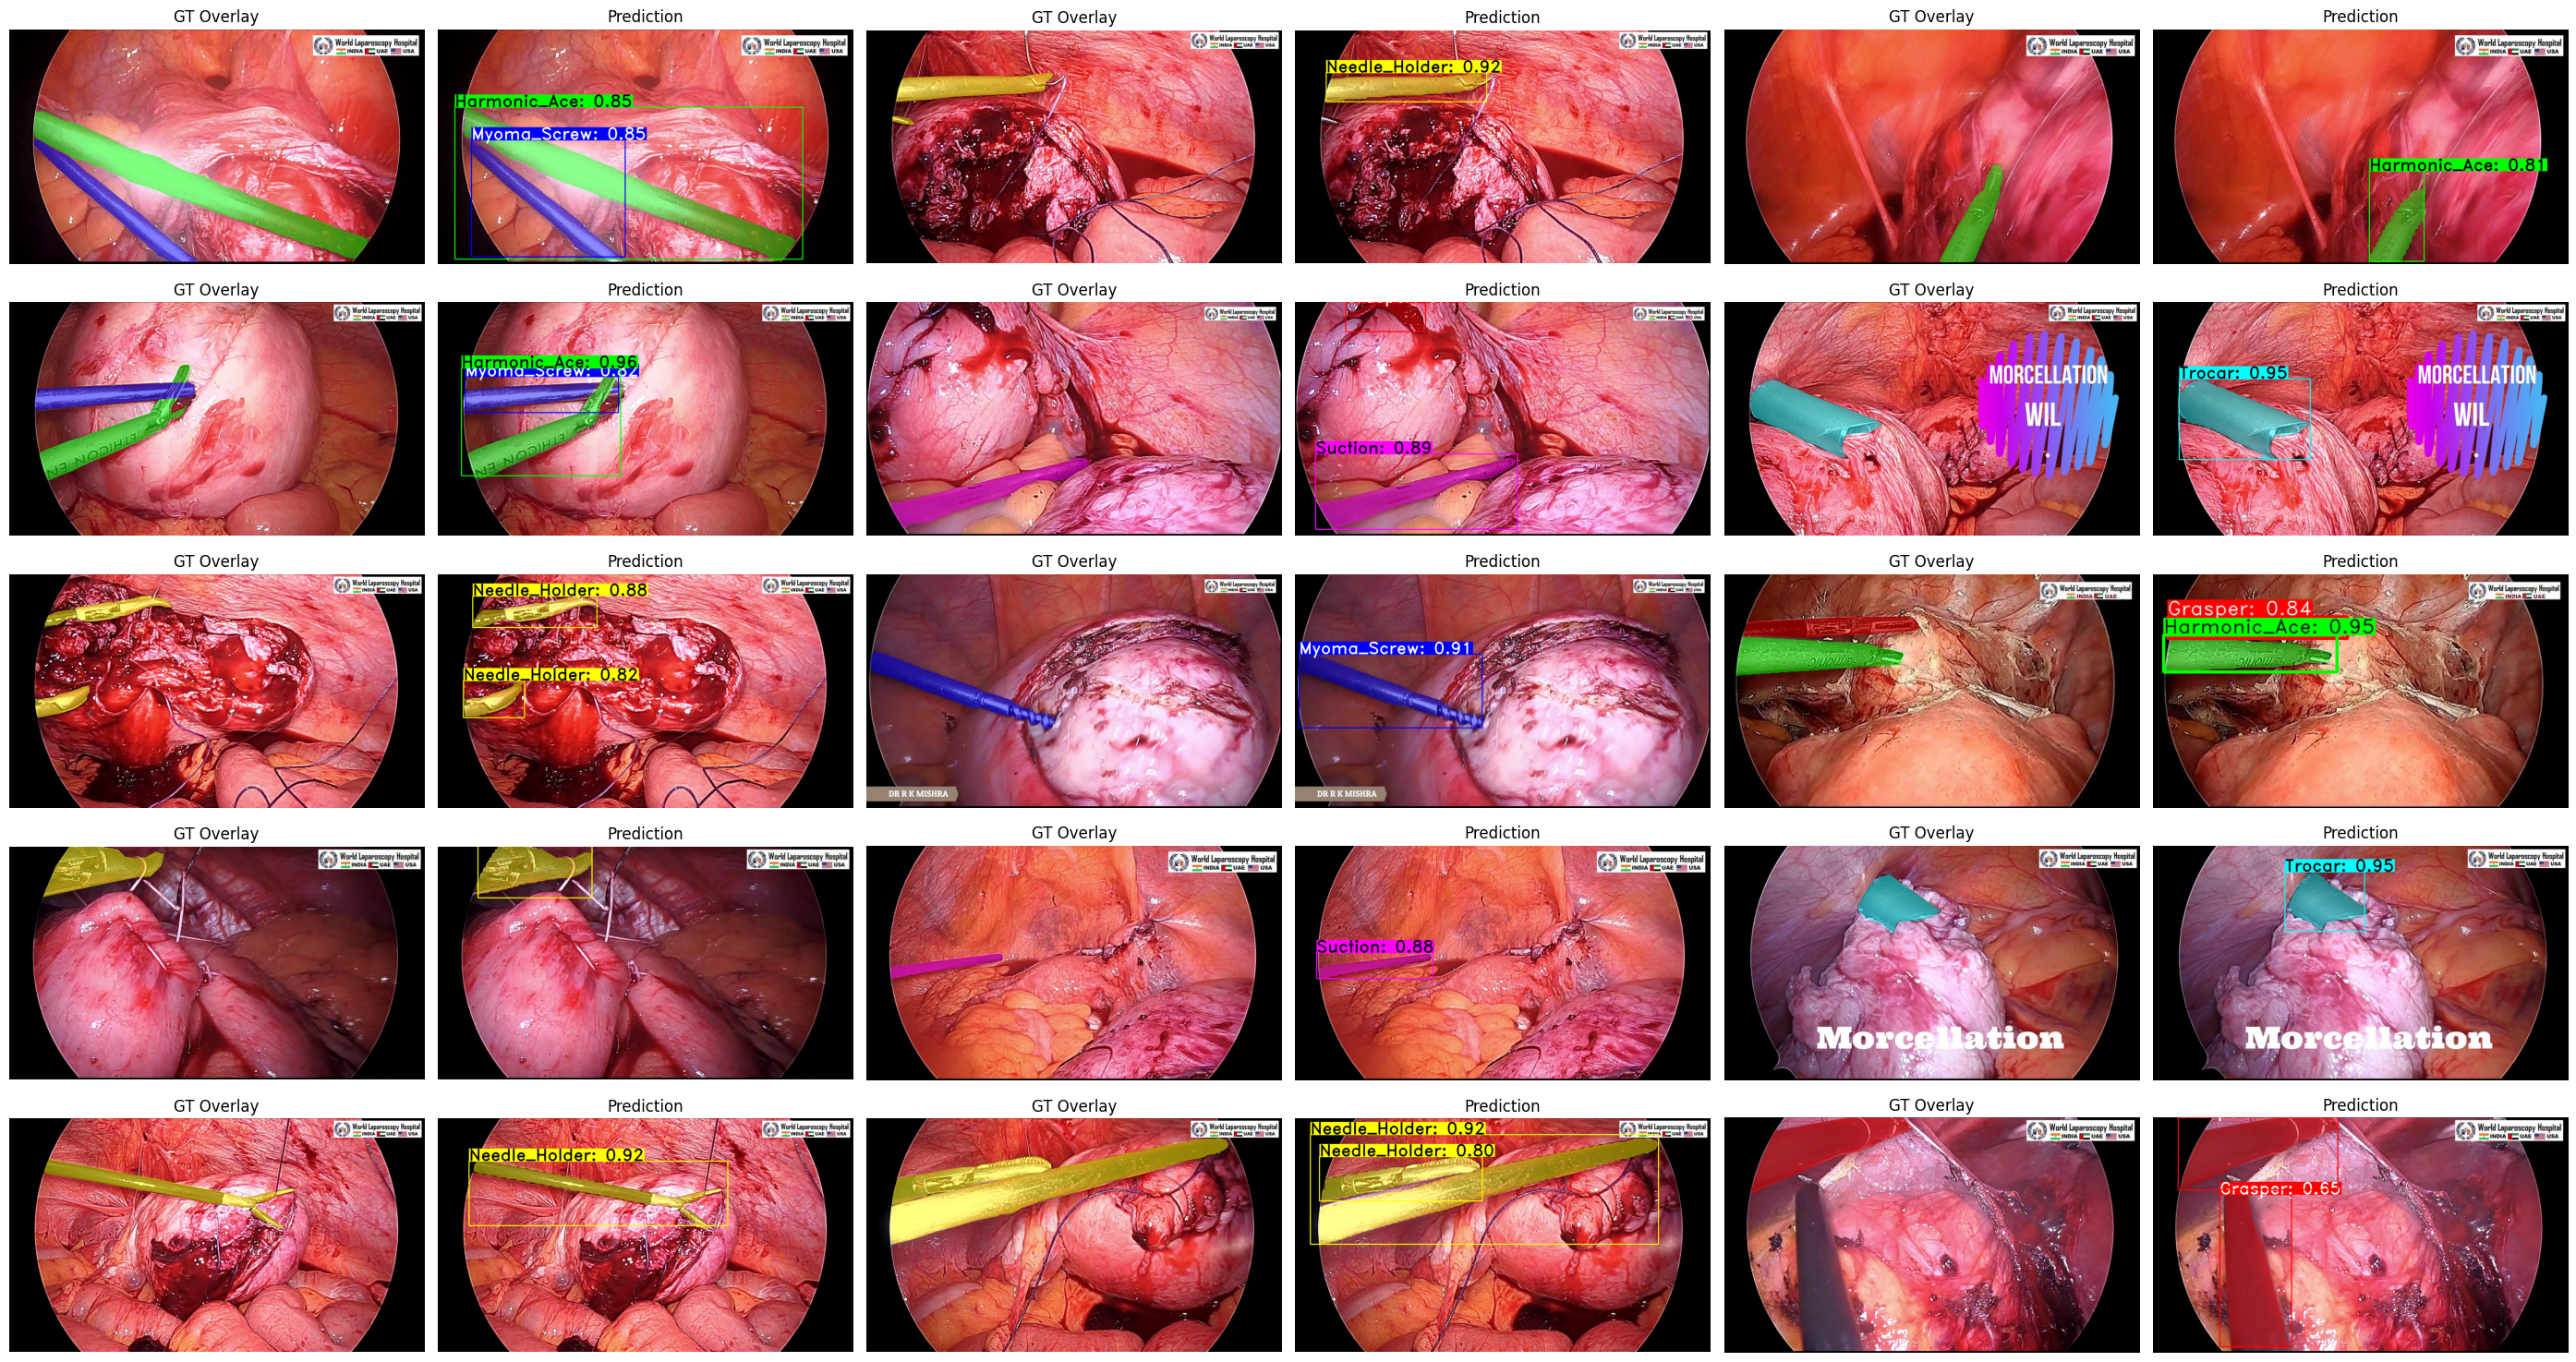

In [64]:
# === Call function: choose how many images you want
visualize_inference_grid(n_images=15)